<a href="https://colab.research.google.com/github/imhemayatsangin/Pneumonia-detection-using-CNN-architecture/blob/main/Pneumonia_detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/My Drive/Dataset'

/content/drive/My Drive/Dataset


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Weight for class 0: 1.94
Weight for class 1: 0.67
Epoch 1/75
163/163 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.6787

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 1376s 8s/step - loss: 0.5321 - accuracy: 0.6787 - val_loss: 0.4075 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 2/75
163/163 [==============================] - 106s 647ms/step - loss: 0.2569 - accuracy: 0.8882 - val_loss: 0.2757 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 3/75
163/163 [==============================] - 105s 642ms/step - loss: 0.2275 - accuracy: 0.9076 - val_loss: 0.2716 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 4/75
163/163 [==============================] - 105s 645ms/step - loss: 0.2004 - accuracy: 0.9151 - val_loss: 0.2709 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 5/75
163/163 [==============================] - 104s 640ms/step - loss: 0.1957 - accuracy: 0.9235 - val_loss: 0.2381 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 6/75
163/163 [==============================] - 101s 621ms/step - loss: 0.1589 - accuracy: 0.9356 - val_loss: 0.2916 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 7/75
163/163 [==============================] - 99s 6

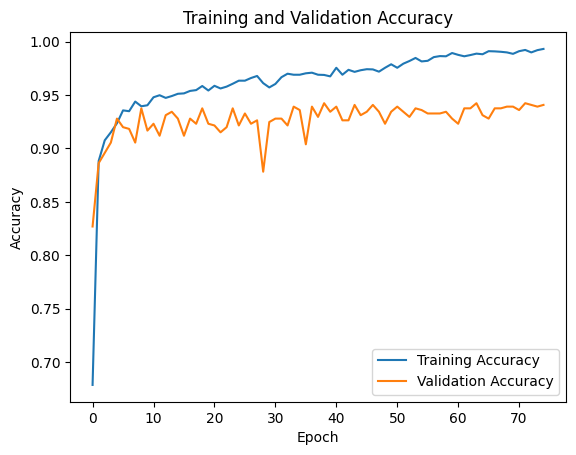

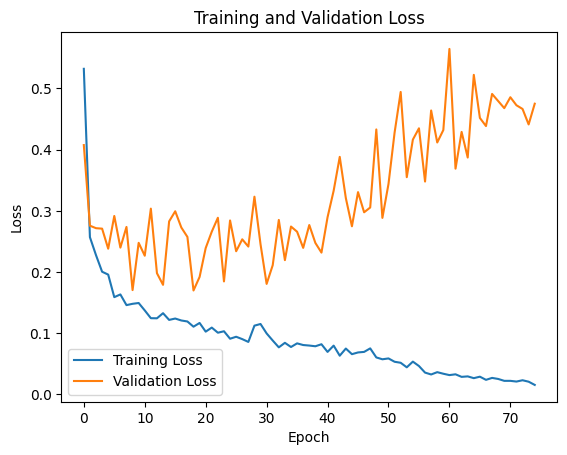

20/20 [==============================] - 6s 270ms/step


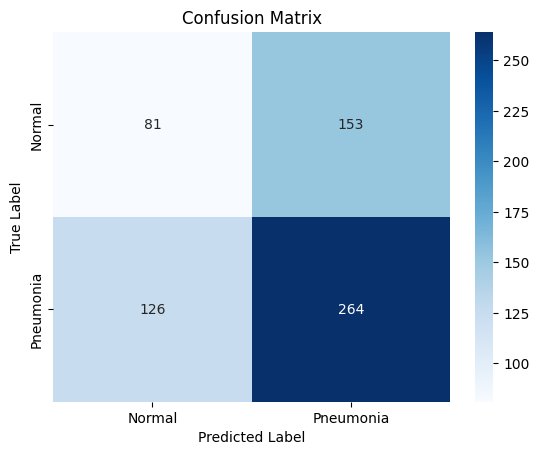

Classification Report:
               precision    recall  f1-score   support

      Normal       0.39      0.35      0.37       234
   Pneumonia       0.63      0.68      0.65       390

    accuracy                           0.55       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.55      0.55       624

Example 77 - True label: Normal, Predicted label: Normal


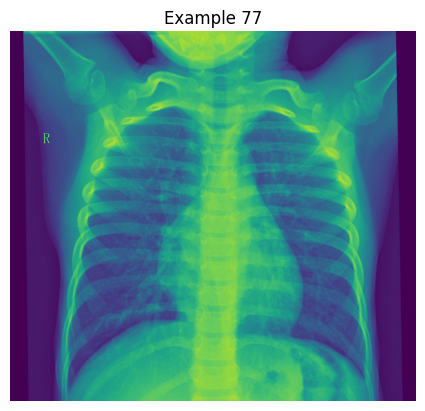

Example 340 - True label: Pneumonia, Predicted label: Pneumonia


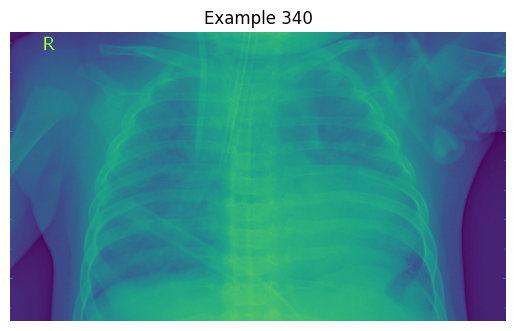

Example 399 - True label: Pneumonia, Predicted label: Normal


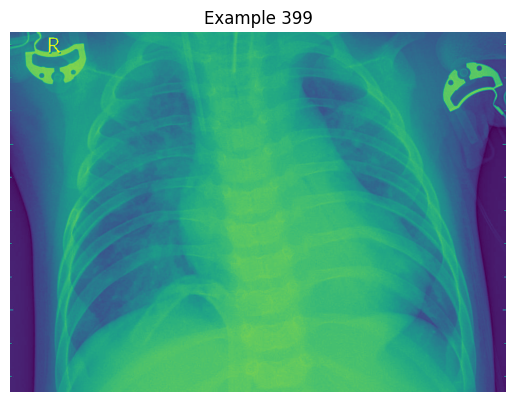

Example 42 - True label: Normal, Predicted label: Pneumonia


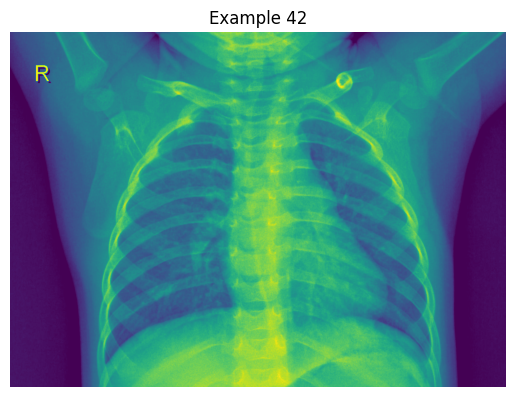

Example 306 - True label: Pneumonia, Predicted label: Pneumonia


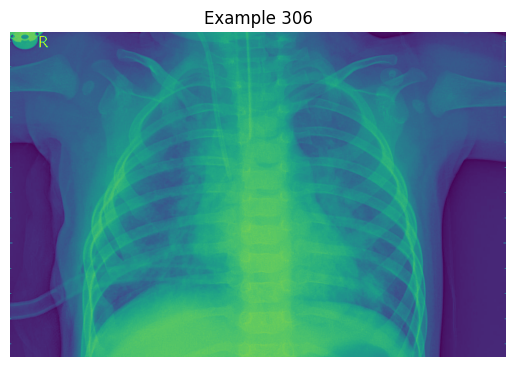

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Count the number of samples for each class in the training set
COUNT_NORMAL = sum(train_generator.classes == 0)
COUNT_PNEUMONIA = sum(train_generator.classes == 1)
TRAIN_IMG_COUNT = len(train_generator.filenames)

# Correct for data imbalance
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

# Build a deeper CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Model Checkpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=75,
    validation_data=test_generator,
    callbacks=[lr_scheduler, checkpoint],
    class_weight=class_weight  # Add class weights here
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Display a few examples with predictions
sample_indices = np.random.choice(len(y_true), size=5, replace=False)

for index in sample_indices:
    true_label = "Pneumonia" if y_true[index] == 1 else "Normal"
    pred_label = "Pneumonia" if y_pred[index] == 1 else "Normal"

    print(f"Example {index + 1} - True label: {true_label}, Predicted label: {pred_label}")

    # Display the corresponding image
    img_path = test_generator.filepaths[index]
    img = plt.imread(img_path)

    plt.imshow(img)
    plt.title(f"Example {index + 1}")
    plt.axis('off')
    plt.show()


In [ ]:
r=model.save('finalaccuracy')

In [ ]:
from google.colab import drive
from tensorflow.keras.models import save_model

# Mount Google Drive
drive.mount('/content/drive')

# Define the path on Google Drive where you want to save the model
drive_path = '/content/drive/My Drive/Pneumoniacnn_model'

# Save the model to the specified path
save_model(model, drive_path, save_format='tf')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
